# Introduction/Abstract

Data set from King County Washington.

# Packages Needed/Setting Global Variables

In [58]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [59]:
def Decade(List):
    decade_list=[]
    oldest = List.min()
    i=0
    for x in List:
        i += 1
        while len(decade_list) < i:
            if (x >= oldest) & (x < (oldest+10)):
                decade_list.append('{}-{}'.format(oldest,(oldest+10)))
            oldest += 10
        oldest = List.min()
    return decade_list

In [60]:
def zoningLat(List):
    lowest = List.min()
    highest = List.max()
    distance = highest - lowest
    distance = math.ceil(distance*69)
    zones = []
    for entry in List:
        for zone in list(range(1,distance+1)):
            if ((lowest+(zone-1)/69) <= entry) &(entry < (lowest + zone/69)):
                zones.append(zone)
    return zones

def zoningLong(List):
    lowest = List.min()
    highest = List.max()
    distance = highest-lowest
    distance = math.ceil(distance*54.6)
    zones = []
    for entry in List:
        for zone in list(range(1,distance+1)):
            if ((lowest+(zone-1)/54.6) <= entry) & (entry < (lowest + zone/54.6)):
                zones.append(zone)
    return zones

In [61]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# EDA

## Questions about the Data

## Import and Clean the Data

In [62]:
# Import the dataset
df = pd.read_csv('kc_house_data.csv')

#Dropping id column
df = df.drop(['id'],axis=1)

# Creating a new column for the year sold, dropping origianl date
df['year_sold'] = df.date.apply(lambda x: x[-4:]).astype(int)
df = df.drop(['date'], axis=1)

# Changing bedroom number for outlier, I think it was a typo of hitting 3 twice
# based off of the sqft
df.at[15856, 'bedrooms'] = 3

# Replacing NaN values in 'waterfront' with 0
df['waterfront'] = df['waterfront'].fillna(0)

# Replacing NaN values in view with the median/mode value which is 0 (63 entries)
# 0 means house was not viewed
df['view'] = df['view'].fillna(0)

# Replacing ? in sqft_basement and converting to float
df['sqft_basement'] = df['sqft_basement'].replace('?',0).astype(float)

# yr_renovated and renovated columns
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['Renovated'] = df['yr_renovated'] > 0
df['Renovated'] = df['Renovated'].astype(int)
df['yr_renovated'] = df['yr_renovated'].replace(0,df['yr_built'])

#Adding column for age when sold
df['Age_When_Sold'] = df['year_sold'] - df['yr_built']

#Adding column for years since renovation when sold and dropping yr_renovated
df['Age_Since_Renovation'] = df['year_sold'] - df['yr_renovated']

#Adding interaction variable Renovated*Age since renovation
df['Renovated*Age'] = df['Renovated'] * df['Age_Since_Renovation']

#Adding zones for Lat and Long
df['Lat_Zones'] = zoningLat(df['lat'])
df['Long_Zones'] = zoningLong(df['long'])
df['Lat_Zones'] = df['Lat_Zones'].astype(str)
df['Long_Zones'] = df['Long_Zones'].astype(str)
#df['Zones'] = df['Lat_Zones'] + 'x' + df['Long_Zones']
df = df.drop(['lat','long','Long_Zones','Lat_Zones'],axis=1)

#Grouping year built by decade
df['yr_built'] = Decade(df.yr_built)

#Dropping 'year_sold',only seems to have two years, not valuable category
df = df.drop(['year_sold'], axis=1)

In [76]:
#Creating Dummie Variables double check this list
#Taking out bedrooms, bathrooms, floors, view, condition
dummy_list = ['grade', 'yr_built', 'zipcode'
                ] #Add 'Zones' back in later
dum=df[dummy_list].astype('category')
dummies = pd.get_dummies(dum[dummy_list],prefix=dummy_list,drop_first=True)
df_preprocessed = df.drop(dummy_list, axis=1)
df_preprocessed = pd.concat([df_preprocessed,dummies],axis=1)

In [64]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Renovated,Age_When_Sold,Age_Since_Renovation,Renovated*Age
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1950-1960,1955.0,98178,1340,5650,0,59,59.0,0.0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1950-1960,1991.0,98125,1690,7639,1,63,23.0,23.0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1930-1940,1933.0,98028,2720,8062,0,82,82.0,0.0
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1960-1970,1965.0,98136,1360,5000,0,49,49.0,0.0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1980-1990,1987.0,98074,1800,7503,0,28,28.0,0.0


## Notes

# Modeling

## First Model

In [65]:
#Omitting zones for now, too much data to process
y = df_preprocessed['price']
X = df_preprocessed.drop(['price'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [66]:
X_train_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_int).fit()
model.summary()
#Adj. R-squared values
#First run 0.853
#Second run 0.850 (after taking out yr_renovated)
#Third run 0.857 (after taking out Age_Since_Renovation)
#Fourth run 0.851 (after taking out sqft_living)
#Fifth run 0.851 (after taking out Renovated*Age)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     802.9
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        18:54:54   Log-Likelihood:            -2.3010e+05
No. Observations:               17277   AIC:                         4.604e+05
Df Residuals:                   17169   BIC:                         4.613e+05
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.852e+07   4.95e+06    -11.833      0.000   -6.82e+07   -4.88e+07
bedrooms             -1.357e+04   1707.085     -7.947      0.000   -1.69e+04   -1.02e+04
bathrooms             2.174e+04   2776.127      7.831      0.000    1.63e+04    2.72e+04
sqft_living             70.2257     16.027      4.382      0.000      38.811     101.640
sqft_lot                 0.2085      0.040      5.178      0.000       0.130       0.287
floors               -2.776e+04   3503.795     -7.922      0.000   -3.46e+04   -2.09e+04
waterfront            6.763e+05   1.51e+04     44.742      0.000    6.47e+05    7.06e+05
view                   5.41e+04   1808.515     29.915      0.000    5.06e+04    5.76e+04
condition             3.253e+04   2022.114     16.087      0.000    2.86e+04    3.65e+04
sqft_above              90.8922     16.008      5.678      0.000      59.514     122.270
sqft_basement           44.3367     15.842      2.799      0.005      13.284      75.389
yr_renovated          2.902e+04   2456.751     11.813      0.000    2.42e+04    3.38e+04
sqft_living15           18.6493      3.006      6.204      0.000      12.757      24.541
sqft_lot15              -0.1252      0.062     -2.015      0.044      -0.247      -0.003
Renovated             1.639e+05   2.19e+04      7.500      0.000    1.21e+05    2.07e+05
Age_When_Sold         -280.3280    495.157     -0.566      0.571   -1250.886     690.230
Age_Since_Renovation   2.98e+04   2473.807     12.047      0.000     2.5e+04    3.47e+04
Renovated*Age        -3595.8947    435.683     -8.253      0.000   -4449.878   -2741.912
grade_4              -8.957e+04   1.51e+05     -0.592      0.554   -3.86e+05    2.07e+05
grade_5              -1.276e+05   1.49e+05     -0.859      0.390   -4.19e+05    1.64e+05
grade_6              -1.205e+05   1.48e+05     -0.813      0.416   -4.11e+05     1.7e+05
grade_7               -1.09e+05   1.48e+05     -0.735      0.462   -3.99e+05    1.82e+05
grade_8              -8.421e+04   1.48e+05     -0.568      0.570   -3.75e+05    2.06e+05
grade_9              -1.011e+04   1.48e+05     -0.068      0.946   -3.01e+05    2.81e+05
grade_10              1.116e+05   1.48e+05      0.752      0.452   -1.79e+05    4.03e+05
grade_11              3.206e+05   1.49e+05      2.155      0.031     2.9e+04    6.12e+05
grade_12              7.684e+05    1.5e+05      5.132      0.000    4.75e+05    1.06e+06
grade_13              1.297e+06   1.57e+05      8.264      0.000    9.89e+05     1.6e+06
yr_built_1910-1920    1.247e+04   9598.373      1.299      0.194   -6343.303    3.13e+04
yr_built_1920-1930    1.714e+04   1.15e+04      1.488      0.137   -5440.519    3.97e+04
yr_built_1930-1940    3.538e+04   1.57e+04      2.249      0.025    4540.545    6.62e+04
yr_built_1940-1950    1.403e+04   1.81e+04      0.774    

## Looking at Multicollinearity

In [67]:
df_corr_test = df.iloc[:,1:21]
df_corr_test.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Renovated,Age_When_Sold,Age_Since_Renovation,Renovated*Age
0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1950-1960,1955.0,98178,1340,5650,0,59,59.0,0.0
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1950-1960,1991.0,98125,1690,7639,1,63,23.0,23.0
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1930-1940,1933.0,98028,2720,8062,0,82,82.0,0.0
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1960-1970,1965.0,98136,1360,5000,0,49,49.0,0.0
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1980-1990,1987.0,98074,1800,7503,0,28,28.0,0.0


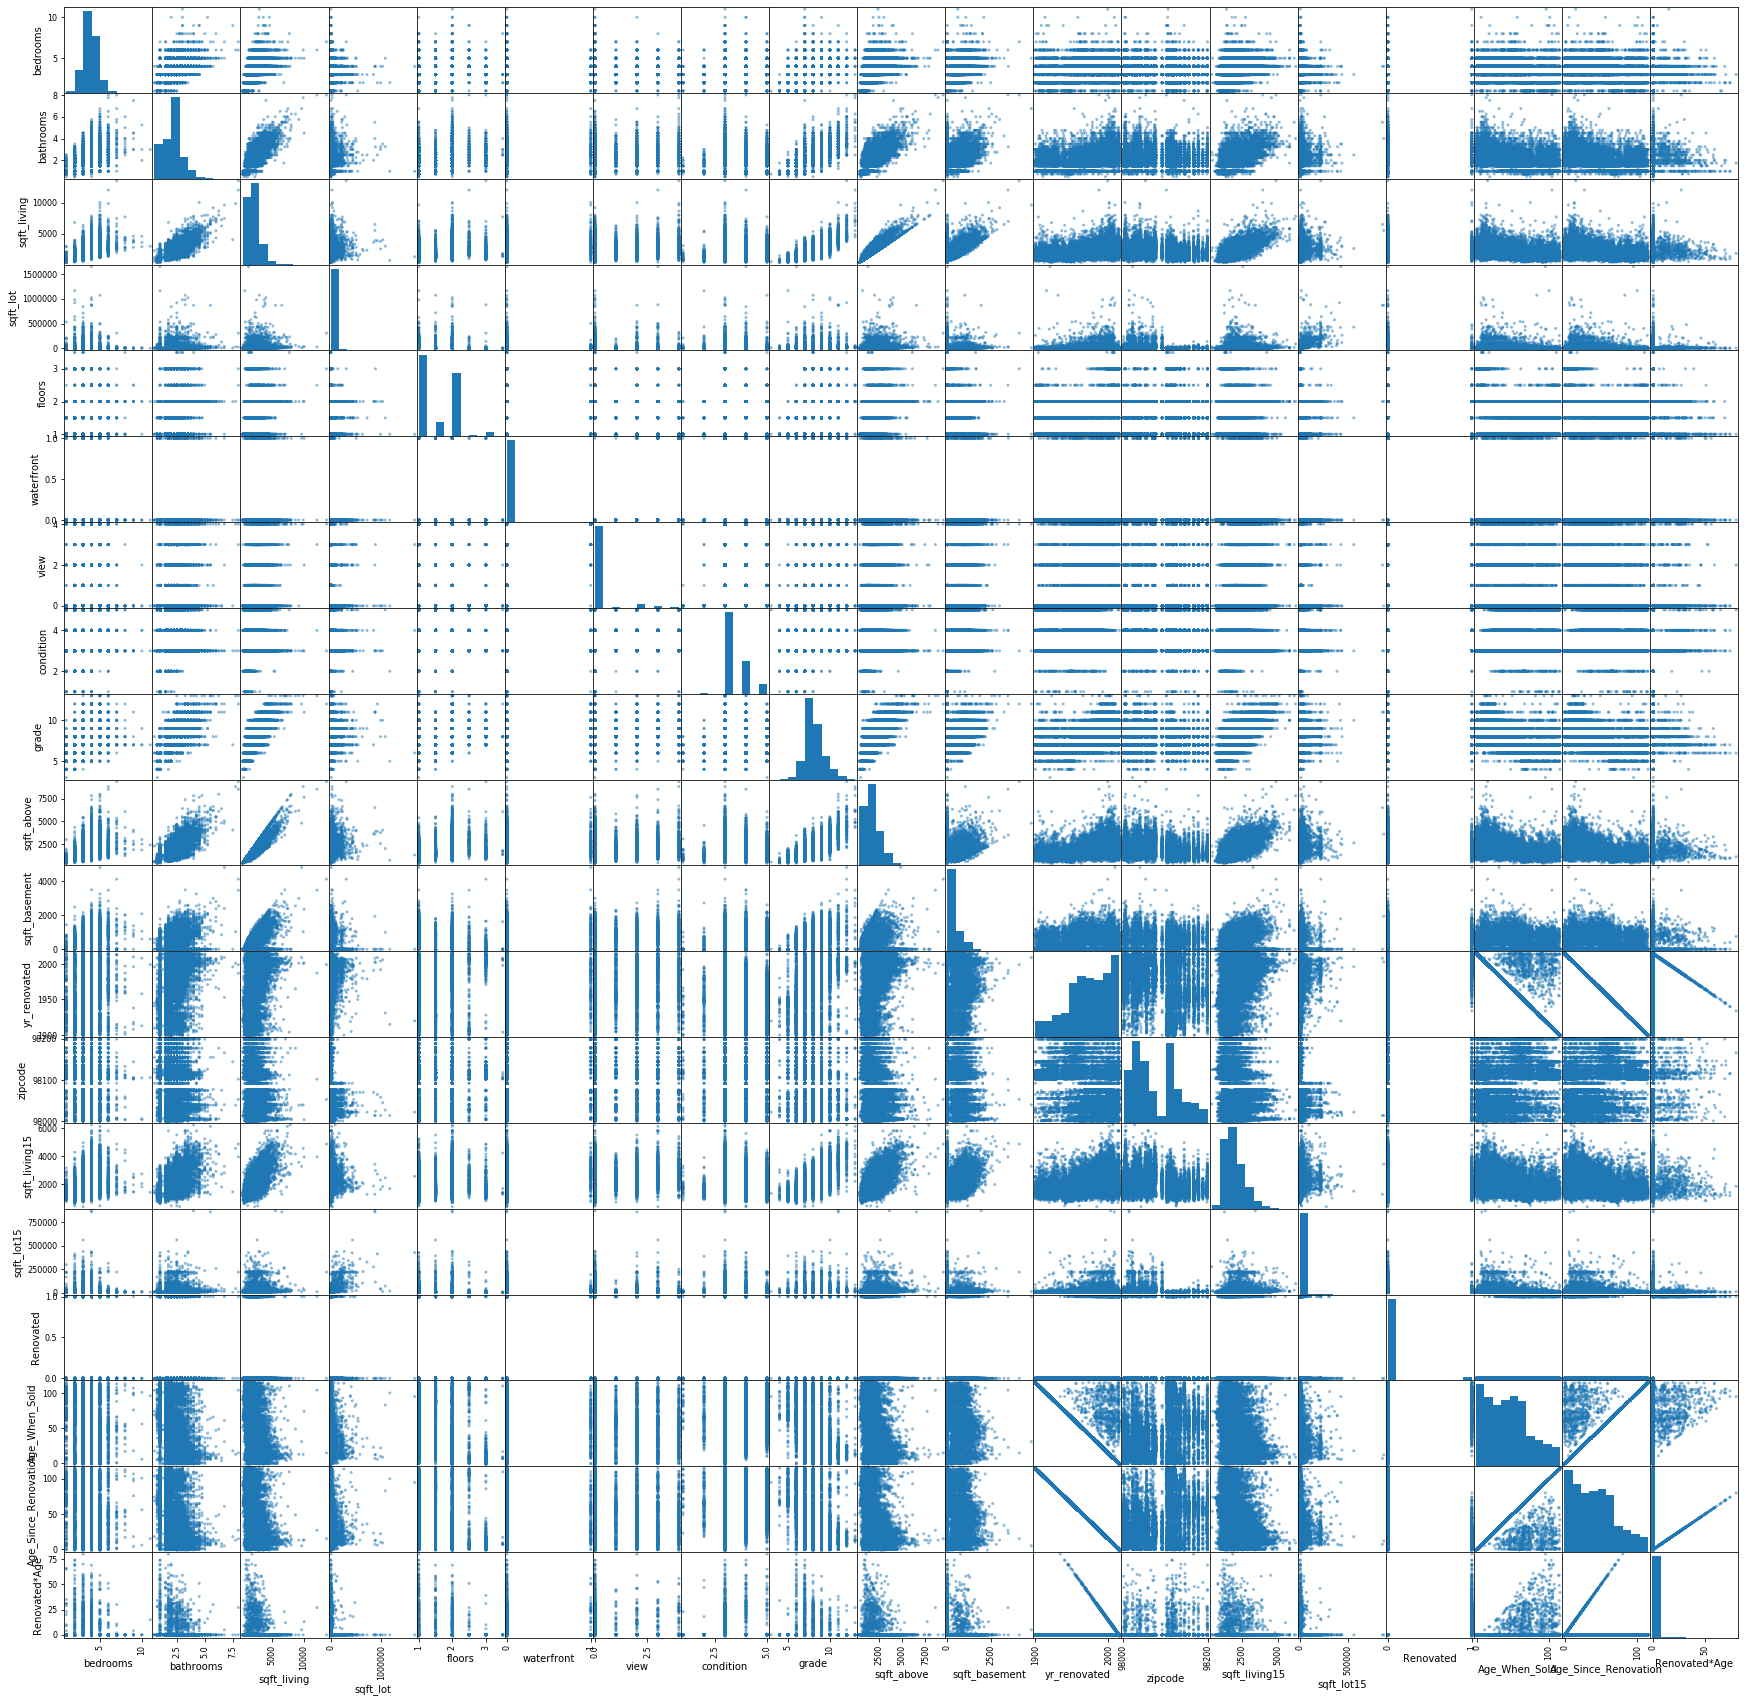

In [68]:
pd.plotting.scatter_matrix(df_corr_test,figsize  = [30, 30]);
plt.show()

In [69]:
test_corr=df_corr_test.corr().abs().stack().reset_index().sort_values(0, ascending=False)
test_corr['pairs'] = list(zip(test_corr.level_0, test_corr.level_1))
test_corr.set_index(['pairs'],inplace=True)
test_corr.drop(['level_0','level_1'],axis=1,inplace=True)
test_corr.columns = ['cc']
test_corr.drop_duplicates(inplace=True)
test_corr[(test_corr.cc >.75) & (test_corr.cc<1)]

,cc
pairs,
"(Age_Since_Renovation, yr_renovated)",0.999870
"(Age_When_Sold, Age_Since_Renovation)",0.926424
"(yr_renovated, Age_When_Sold)",0.926400
"(sqft_living, sqft_above)",0.876448
"(sqft_living, grade)",0.762779
"(sqft_living15, sqft_living)",0.756402
"(Renovated, Renovated*Age)",0.756165
"(sqft_above, grade)",0.756073
"(sqft_living, bathrooms)",0.755758


In [70]:
#Looks like yr_built and yr_renovated is highly correlated, dropping yr_renovated column
#Looks like Age_When_sold and Age_Since_Renovation is highly correlated, dropping Age_Since_Renovation
#Looks like sqft_living and sqft_above is highly correlated, dropping sqft_living
#Looks like Renovated*Age and Renovated is highly correlated, dropping Renovated*Age
#Looks like sqft_living and sqft_living15 is highly correlated, dropping sqft_living
#Did this in EDA section

In [71]:
#Correlations that are getting dropped
df = df.drop(['yr_renovated'],axis=1)
df = df.drop(['Age_Since_Renovation'],axis=1)
df = df.drop(['sqft_living'],axis=1)
df = df.drop(['Renovated*Age'],axis=1)

In [77]:
df_corr_test2 = df.iloc[:,1:17]
df_corr_test2.head()

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,Renovated,Age_When_Sold
0,3,1.00,5650,1.0,0.0,0.0,3,7,1180,0.0,1950-1960,98178,1340,5650,0,59
1,3,2.25,7242,2.0,0.0,0.0,3,7,2170,400.0,1950-1960,98125,1690,7639,1,63
2,2,1.00,10000,1.0,0.0,0.0,3,6,770,0.0,1930-1940,98028,2720,8062,0,82
3,4,3.00,5000,1.0,0.0,0.0,5,7,1050,910.0,1960-1970,98136,1360,5000,0,49
4,3,2.00,8080,1.0,0.0,0.0,3,8,1680,0.0,1980-1990,98074,1800,7503,0,28


In [78]:
test_corr2=df_corr_test2.corr().abs().stack().reset_index().sort_values(0, ascending=False)
test_corr2['pairs'] = list(zip(test_corr2.level_0, test_corr2.level_1))
test_corr2.set_index(['pairs'],inplace=True)
test_corr2.drop(['level_0','level_1'],axis=1,inplace=True)
test_corr2.columns = ['cc']
test_corr2.drop_duplicates(inplace=True)
test_corr2[(test_corr2.cc >.75) & (test_corr2.cc<1)]

,cc
pairs,
"(grade, sqft_above)",0.756073


In [74]:
#Even though it's highly correlated going to keep it because they are two separate things.

In [76]:
#Creating Dummie Variables double check this list
#Taking out bedrooms, bathrooms, floors, view, condition
dummy_list = ['grade', 'yr_built', 'zipcode'
                ] #Add 'Zones' back in later
dum=df[dummy_list].astype('category')
dummies = pd.get_dummies(dum[dummy_list],prefix=dummy_list,drop_first=True)
df_preprocessed = df.drop(dummy_list, axis=1)
df_preprocessed = pd.concat([df_preprocessed,dummies],axis=1)

## Second Model after removing collinearity

In [79]:
#Omitting zones for now, too much data to process
y2 = df_preprocessed['price']
X2 = df_preprocessed.drop(['price'],axis=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)

In [80]:
X_train_int2 = sm.add_constant(X_train2)
model2 = sm.OLS(y_train2, X_train_int2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     828.9
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:01:15   Log-Likelihood:            -2.3048e+05
No. Observations:               17277   AIC:                         4.612e+05
Df Residuals:                   17173   BIC:                         4.620e+05
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -9.726e+04   1.59e+05     -0.611      0.541   -4.09e+05    2.15e+05
bedrooms           -1.436e+04   1746.020     -8.223      0.000   -1.78e+04   -1.09e+04
bathrooms           2.967e+04   2800.204     10.595      0.000    2.42e+04    3.52e+04
sqft_lot               0.2664      0.041      6.504      0.000       0.186       0.347
floors             -2.976e+04   3576.951     -8.321      0.000   -3.68e+04   -2.28e+04
waterfront          6.333e+05   1.53e+04     41.309      0.000    6.03e+05    6.63e+05
view                5.516e+04   1823.509     30.252      0.000    5.16e+04    5.87e+04
condition           3.196e+04   2060.138     15.516      0.000    2.79e+04     3.6e+04
sqft_above           162.8096      3.310     49.181      0.000     156.321     169.298
sqft_basement        112.6401      3.750     30.034      0.000     105.289     119.991
sqft_living15         16.1907      3.066      5.282      0.000      10.182      22.199
sqft_lot15            -0.1467      0.063     -2.340      0.019      -0.270      -0.024
Renovated           5.453e+04   6742.774      8.087      0.000    4.13e+04    6.77e+04
Age_When_Sold       1023.0818    408.791      2.503      0.012     221.809    1824.355
grade_4            -1.144e+05   1.55e+05     -0.739      0.460   -4.18e+05    1.89e+05
grade_5            -1.647e+05   1.52e+05     -1.084      0.278   -4.62e+05    1.33e+05
grade_6            -1.502e+05   1.52e+05     -0.992      0.321   -4.47e+05    1.47e+05
grade_7            -1.433e+05   1.52e+05     -0.945      0.344    -4.4e+05    1.54e+05
grade_8            -1.196e+05   1.52e+05     -0.789      0.430   -4.17e+05    1.77e+05
grade_9            -4.407e+04   1.52e+05     -0.291      0.771   -3.41e+05    2.53e+05
grade_10            7.997e+04   1.52e+05      0.527      0.598   -2.18e+05    3.77e+05
grade_11            2.825e+05   1.52e+05      1.858      0.063   -1.55e+04    5.81e+05
grade_12            6.446e+05   1.53e+05      4.210      0.000    3.44e+05    9.45e+05
grade_13            1.743e+06   1.59e+05     10.989      0.000    1.43e+06    2.05e+06
yr_built_1910-1920  2.036e+04   9890.971      2.058      0.040     967.935    3.97e+04
yr_built_1920-1930  3.458e+04   1.17e+04      2.956      0.003    1.16e+04    5.75e+04
yr_built_1930-1940   5.57e+04    1.6e+04      3.480      0.001    2.43e+04    8.71e+04
yr_built_1940-1950  4.634e+04   1.82e+04      2.540      0.011    1.06e+04    8.21e+04
yr_built_1950-1960  4.008e+04   2.18e+04      1.840      0.066   -2622.713    8.28e+04
yr_built_1960-1970  4.591e+04   2.56e+04      1.794      0.073   -4263.024    9.61e+04
yr_built_1970-1980  4.518e+04   2.98e+04      1.515      0.130   -1.33e+04    1.04e+05
yr_built_1980-1990  5.999e+04   3.33e+04      1.799      0.072   -5380.092    1.25e+05
yr_built_1990-2000  5.016e+04    3.7e+

## Stepwise Selection of features

In [81]:
results = stepwise_selection(X_train2,y_train2)

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Add  bathrooms                      with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  view                           with p-value 0.0
Add  zipcode_98004                  with p-value 0.0
Add  Age_When_Sold                  with p-value 0.0
Add  sqft_basement                  with p-value 1.92369e-297
Add  zipcode_98039                  with p-value 6.60976e-234
Add  zipcode_98112                  with p-value 1.52301e-167
Add  waterfront                     with p-value 2.25828e-145
Add  bedrooms                       with p-value 7.24801e-137
Add  zipcode_98040                  with p-value 1.86101e-124
Add  grade_13                       with p-value 3.63144e-116
Add  grade_11                       with p-value 4.19537e-99
Add  grade_12                       with p-value 1.61103e-119
Add  grade_10                       with p-value 1.08525e-150
Add  grade_9                        with p-value 9.26862e-171
Add  grade_8                        with p-value 8.412

In [82]:
len(results)

75

## Third Model using Selected Features

In [83]:
TestFeatures=X_train2[results]
TestFeatures.head()

,bathrooms,sqft_above,view,zipcode_98004,Age_When_Sold,sqft_basement,zipcode_98039,zipcode_98112,waterfront,bedrooms,zipcode_98040,grade_13,grade_11,grade_12,grade_10,grade_9,grade_8,zipcode_98033,zipcode_98023,zipcode_98105,zipcode_98119,zipcode_98115,zipcode_98103,zipcode_98199,zipcode_98117,zipcode_98109,zipcode_98102,zipcode_98107,zipcode_98122,zipcode_98052,zipcode_98006,zipcode_98116,zipcode_98144,zipcode_98008,zipcode_98005,zipcode_98034,zipcode_98053,zipcode_98092,zipcode_98136,zipcode_98029,zipcode_98125,condition,zipcode_98177,zipcode_98074,zipcode_98007,zipcode_98126,zipcode_98133,zipcode_98027,zipcode_98118,zipcode_98075,zipcode_98155,zipcode_98072,yr_built_2010-2020,floors,Renovated,zipcode_98028,zipcode_98106,sqft_lot,zipcode_98011,sqft_living15,zipcode_98022,zipcode_98042,zipcode_98108,zipcode_98077,zipcode_98024,zipcode_98056,zipcode_98146,zipcode_98059,zipcode_98065,zipcode_98019,zipcode_98045,zipcode_98014,yr_built_1990-2000,yr_built_1930-1940,zipcode_98003
8767,2.25,1340,0.0,0,50,1000.0,0,0,0.0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,14279,0,2340,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20178,2.50,2630,0.0,0,4,0.0,0,0,0.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,1,2.0,0,0,0,5701,0,2770,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5288,3.50,2560,0.0,0,10,900.0,0,0,0.0,4,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0,0,3997,0,1860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1063,1.50,1410,0.0,0,61,0.0,0,0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,1.0,0,0,0,9000,0,1910,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20222,2.75,2820,0.0,0,6,0.0,0,0,0.0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,2.0,0,0,0,5348,0,3140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
TestFeatures_X_int = sm.add_constant(TestFeatures)
model3 = sm.OLS(y_train2, TestFeatures_X_int).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1134.
Date:                Tue, 20 Oct 2020   Prob (F-statistic):               0.00
Time:                        19:06:35   Log-Likelihood:            -2.3052e+05
No. Observations:               17277   AIC:                         4.612e+05
Df Residuals:                   17201   BIC:                         4.618e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.422e+05   1.03e+04    -13.770      0.000   -1.62e+05   -1.22e+05
bathrooms           2.986e+04   2749.938     10.859      0.000    2.45e+04    3.53e+04
sqft_above           163.3980      3.282     49.783      0.000     156.965     169.831
view                5.489e+04   1807.496     30.367      0.000    5.13e+04    5.84e+04
zipcode_98004       7.254e+05   1.03e+04     70.543      0.000    7.05e+05    7.46e+05
Age_When_Sold        477.2886     68.551      6.963      0.000     342.922     611.655
sqft_basement        112.7053      3.724     30.262      0.000     105.405     120.005
zipcode_98039       1.196e+06   2.36e+04     50.673      0.000    1.15e+06    1.24e+06
zipcode_98112       6.027e+05   1.11e+04     54.338      0.000    5.81e+05    6.24e+05
waterfront          6.325e+05   1.52e+04     41.546      0.000    6.03e+05    6.62e+05
bedrooms           -1.477e+04   1713.251     -8.620      0.000   -1.81e+04   -1.14e+04
zipcode_98040       4.586e+05    1.1e+04     41.523      0.000    4.37e+05     4.8e+05
grade_13            1.882e+06   4.61e+04     40.840      0.000    1.79e+06    1.97e+06
grade_11            4.246e+05   1.11e+04     38.366      0.000    4.03e+05    4.46e+05
grade_12            7.854e+05   2.08e+04     37.847      0.000    7.45e+05    8.26e+05
grade_10            2.225e+05   7405.550     30.043      0.000    2.08e+05    2.37e+05
grade_9             9.825e+04   5159.757     19.042      0.000    8.81e+04    1.08e+05
grade_8              2.33e+04   3333.289      6.991      0.000    1.68e+04    2.98e+04
zipcode_98033       3.318e+05   8647.962     38.370      0.000    3.15e+05    3.49e+05
zipcode_98023      -4.984e+04   8034.127     -6.203      0.000   -6.56e+04   -3.41e+04
zipcode_98105        4.57e+05   1.24e+04     36.999      0.000    4.33e+05    4.81e+05
zipcode_98119       4.643e+05   1.34e+04     34.662      0.000    4.38e+05    4.91e+05
zipcode_98115       3.077e+05   7785.005     39.530      0.000    2.92e+05    3.23e+05
zipcode_98103       3.148e+05   7929.736     39.696      0.000    2.99e+05     3.3e+05
zipcode_98199       3.544e+05   1.01e+04     35.169      0.000    3.35e+05    3.74e+05
zipcode_98117       2.949e+05   8015.241     36.792      0.000    2.79e+05    3.11e+05
zipcode_98109       4.809e+05   1.65e+04     29.197      0.000    4.49e+05    5.13e+05
zipcode_98102       4.841e+05   1.72e+04     28.209      0.000    4.51e+05    5.18e+05
zipcode_98107       3.227e+05   1.12e+04     28.923      0.000    3.01e+05    3.45e+05
zipcode_98122       3.235e+05   1.06e+04     30.597      0.000    3.03e+05    3.44e+05
zipcode_98052       2.142e+05   7738.299     27.676      0.000    1.99e+05    2.29e+05
zipcode_98006       2.258e+05   8295.039     27.220      0.000     2.1e+05    2.42e+05
zipcode_98116       2.688e+05   1.01e+

## Scaling features

In [98]:
continuous_features = ['bathrooms','sqft_above','Age_When_Sold','sqft_basement',
                       'bedrooms','condition','floors','sqft_lot','sqft_living15']
len(continuous_features)

9

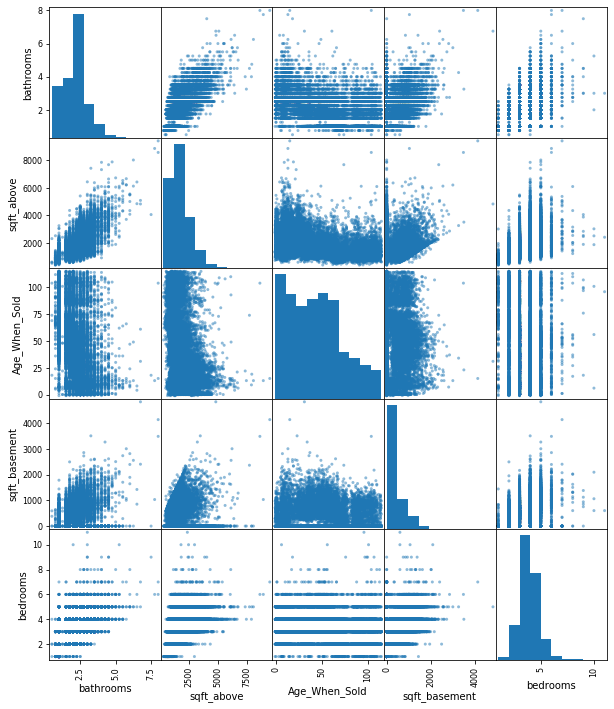

In [99]:
pd.plotting.scatter_matrix(df[continuous_features[:5]], figsize=(10,12));

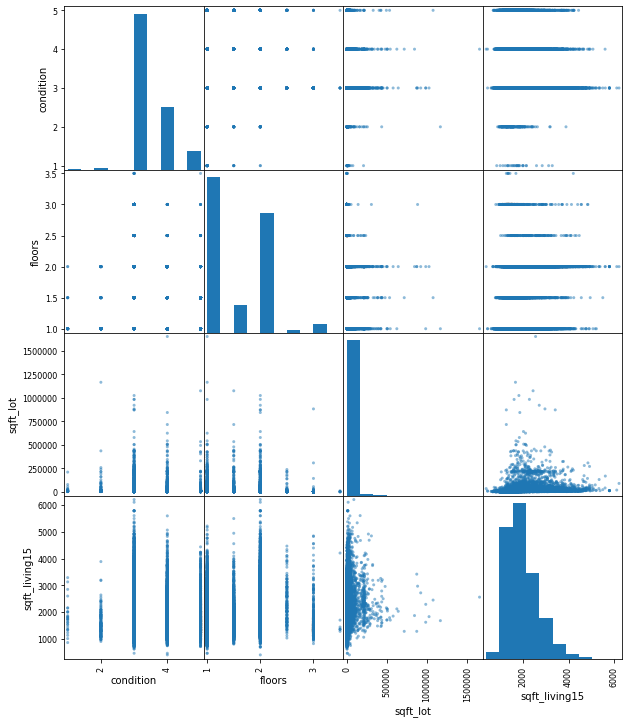

In [100]:
pd.plotting.scatter_matrix(df[continuous_features[5:]], figsize=(10,12));

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


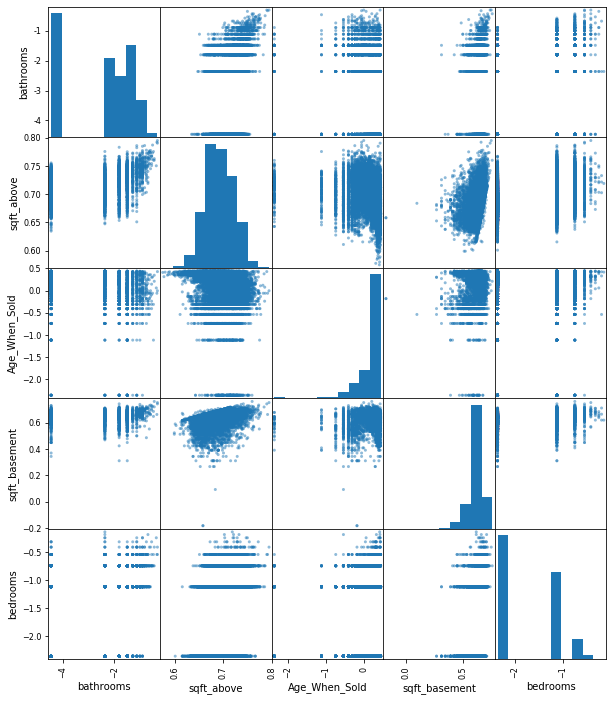

In [106]:
df2=df.copy()
for feature in continuous_features:
    df2[feature] = df[feature].map(lambda x: np.log(x))
pd.plotting.scatter_matrix(df2[continuous_features[:5]], figsize=(10,12));

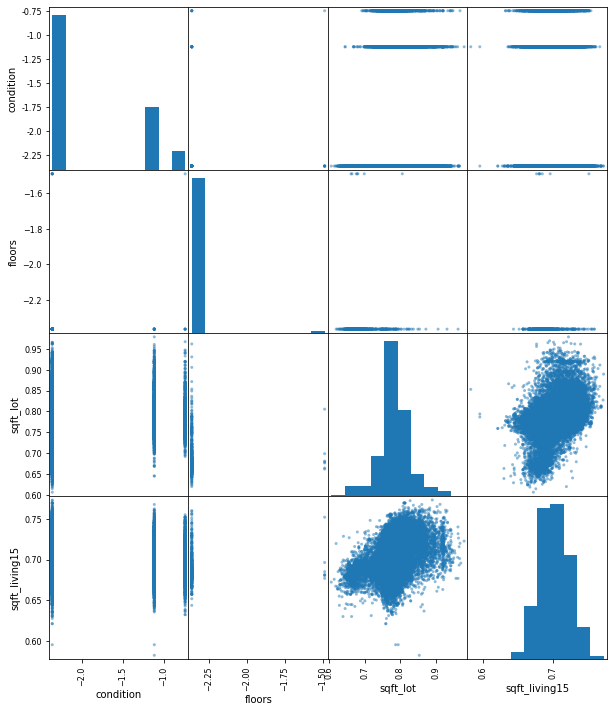

In [107]:
pd.plotting.scatter_matrix(df2[continuous_features[5:]], figsize=(10,12));

In [108]:
# #After looking at log transformation these are the ones that should be transformed.
# Log_transform=['sqft_lot','sqft_living15','sqft_above']
# for feature in Log_transform:
#     df[feature] = df[feature].map(lambda x: np.log(x))

## Actually don't log scale, nan values come up and cant model

## Scratch Work

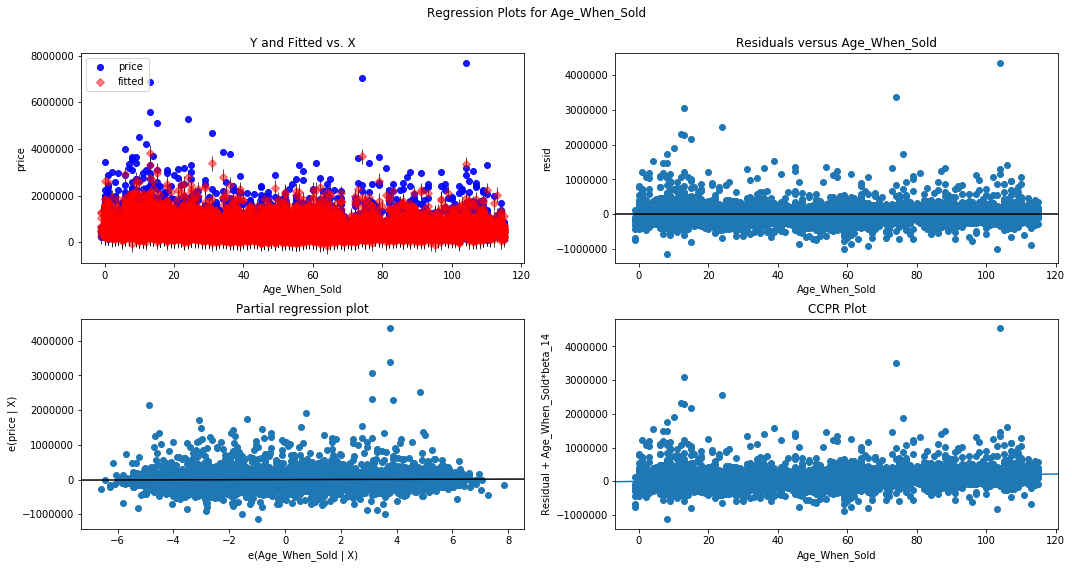

In [88]:
fig7 = plt.figure(figsize=(15,8))
fig7 = sm.graphics.plot_regress_exog(model3, "Age_When_Sold", fig=fig7)
plt.show()

/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


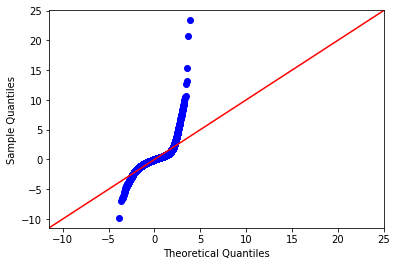

In [89]:
residuals = model3.resid
fig8 = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig8.show()